In [290]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:
%matplotlib inline

In [292]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [293]:
# combine
# fill in make
# fill in mileage, age
# fill in power and engine cap
# fill in policy-related values except depreciation rate
# calculate price based on depreciation rate
# save the values with price and evaluate the performance

In [431]:
df1 = pd.read_csv('./train.csv')
df2 = pd.read_csv('./test.csv')
l = df2.columns.tolist()
df1 = df1[l]
df = pd.concat([df1, df2])
trainLen = len(df1)

In [432]:
print(len(df1) + len(df2))

21784


In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21784 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         21784 non-null  int64  
 1   title              21784 non-null  object 
 2   make               18997 non-null  object 
 3   model              21784 non-null  object 
 4   description        21328 non-null  object 
 5   manufactured       21529 non-null  float64
 6   original_reg_date  418 non-null    object 
 7   reg_date           21522 non-null  object 
 8   type_of_vehicle    21784 non-null  object 
 9   category           21784 non-null  object 
 10  transmission       21784 non-null  object 
 11  curb_weight        21049 non-null  float64
 12  power              18772 non-null  float64
 13  fuel_type          4541 non-null   object 
 14  engine_cap         21716 non-null  float64
 15  no_of_owners       21552 non-null  float64
 16  depreciation       2121

df_valid = df.dropna(subset = ['fuel_type'])

missingfuel_type = df.fuel_type.isnull()
dfm = df[missingfuel_type]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in df_valid.iterrows():
    model = row['model']
    fuel_type = row['fuel_type']
    mapper[model] = fuel_type

for idx, row in dfm.iterrows():
    model = row['model']
    if model in mapper:
        df.at[idx, 'fuel_type'] = mapper[model]

print(df['fuel_type'].isnull().sum())

In [434]:
#fill in make
dfvalid = df.dropna(subset = ['make'])

missingMake = df.make.isnull()
dfm = df[missingMake]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in dfvalid.iterrows():
    model = row['model']
    make = row['make']
    mapper[model] = make

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'make'] = mapper[model]

print(df['make'].isnull().sum())

0


In [435]:
# fill in mileage
df_valid = df.dropna(subset = ['mileage', 'no_of_owners'])
no_of_ownerss = df_valid['no_of_owners'].to_numpy()
caps = df_valid['mileage'].to_numpy()

k = 100
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['no_of_owners'], row['mileage']
    
    if type(row["mileage"]) == float and pd.isna(row["mileage"]):

        diff = np.abs(no_of_ownerss - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'mileage'] = avg
print(df['mileage'].isnull().sum())

0
10000
0
0


In [436]:
# get age and remaining coe
d1 = df['manufactured'].isnull()
df['age'] = df['manufactured'].copy()
df['age'][d1] = df['manufactured'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['original_reg_date'][d1]
def month(x):
    if pd.isna(x):
        return np.nan
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return (2021 - int(x)) * 12
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

def filterNeg(x):
    if x < 0:
        return 0
    return x
    
df['age'] = df['age'].map(month)

d1 = df['reg_date'].isnull()
df['remaining_coe'] = df['reg_date'].copy()
df['remaining_coe'][d1] = df['reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['original_reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['manufactured'][d1]
df['remaining_coe'] = 120 - df['remaining_coe'].map(month)
df['remaining_coe'] = df['remaining_coe'].map(filterNeg)

hasLifeSpan = ~df['lifespan'].isnull()
def get_remaining(x):
    diffFrom2021 = month(x)
    res = -diffFrom2021
    if res < 0:
        res = 0
    return res ##check 2021
df['remaining_coe'][hasLifeSpan] = df['lifespan'][hasLifeSpan].map(get_remaining)


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
G:\softwares\envs\4277lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
G

In [437]:
# get omv
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age']
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

In [438]:
missingOmv = df.omv.isnull()
# print(df[missingOmv]['category'].unique())
# print(df[missingOmv][df.category.str.contains('low mileage')])
# print(df[missingOmv][df.age < 120]['category'])
# print(df[missingOmv])

In [439]:
# get omv
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
# df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age'] // 24 * 24
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning:

In [440]:
df_ = df.copy()
# df_ = df_[:trainLen]
# print(df_[df_.omv.isnull()])
print(len(df_[df_.omv.isnull()]))
# print(len(df_[:trainLen]))
# print(len(df_[trainLen:]))
print(trainLen)

43
16784


In [441]:
df = df_.copy()
print(len(df))
print(len(df) - 5000)
train = df[:trainLen].dropna(subset=['omv'])
trainLen = len(train)
print(trainLen)
test = df[16784:].copy()

print(len(test))

21784
16784
16751
5000


In [276]:
print(test[test.omv.isnull()])

      listing_id                                              title  \
706       861845               Lotus Super Seven (COE till 03/2028)   
1026      974600                    Morris Minor (COE till 06/2030)   
1770      943314          Alfa Romeo Spider 2000 (COE till 07/2030)   
1889      772738              Mercedes-Benz 250S (COE till 04/2029)   
1904     1007657  Jaguar E-Type Series 1 Roadster 3.8M (COE till...   
2015      944008              Mercedes-Benz 280S (COE till 03/2029)   
2062     1018356          Volkswagen Beetle 1200 (COE till 03/2030)   
2282      786155                  Mercedes-Benz 200 (New 10-yr COE)   
2633      982455                       Fiat 500C (COE till 06/2030)   
3224      970068               Mercedes-Benz 200 (COE till 12/2030)   

               make   model  \
706           lotus   super   
1026          honda   minor   
1770  mercedes-benz  spider   
1889  mercedes-benz     250   
1904         jaguar  e-type   
2015  mercedes-benz    280s   
2

In [442]:
omvL = test[test.omv.isnull()].index.tolist()
print(omvL)
test['omv'] = test['omv'].fillna(0)
df = pd.concat([train, test])
# prices = [120000, 33800, 109888, 718000, 718000, 109888] ####
# df[:trainLen] = df[:trainLen].dropna(subset = ['omv'])
df.info()

[706, 1026, 1770, 1889, 1904, 2015, 2062, 2282, 2633, 3224]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21751 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         21751 non-null  int64  
 1   title              21751 non-null  object 
 2   make               21751 non-null  object 
 3   model              21751 non-null  object 
 4   description        21295 non-null  object 
 5   manufactured       21497 non-null  float64
 6   original_reg_date  415 non-null    object 
 7   reg_date           21490 non-null  object 
 8   type_of_vehicle    21751 non-null  object 
 9   category           21751 non-null  object 
 10  transmission       21751 non-null  object 
 11  curb_weight        21040 non-null  float64
 12  power              18765 non-null  float64
 13  fuel_type          4539 non-null   object 
 14  engine_cap         21683 non-null  float64
 15  no_of_owner

In [443]:
print(21751-5000)

16751


In [209]:
# vintage = df_train[df_train.age > 120].dropna(subset=['omv'])

In [210]:
# ## estimated omv
# from sklearn.linear_model import LinearRegression
# df_ = vintage.copy()
# price = np.array(df_['price']).reshape(-1, 1)

# age = np.array(df_['age']).reshape(-1, 1)

# mileage = np.array(df_['mileage']).reshape(-1, 1)

# X = np.concatenate((price, mileage, age), axis=1)
# y = np.array(df_['omv']).reshape(-1, 1)

# reg = LinearRegression().fit(X, y)
# print(reg.score(X, y))
# print(reg.coef_)


NameError: name 'vintage' is not defined

In [ ]:
# missingPriceAges = []
# missingVintage = df[df.omv.isnull()][df.age >= 120]
# idxs = missingVintage.index
# # print(len(missingVintage))
# for idx, row in missingVintage.iterrows():
#     price = row['price']
#     mileage = row['mileage']
#     age = row['age']
#     missingPriceAges.append((price, mileage, age))
# # print(len(missingPriceAges))
# omvs = reg.predict(np.array(missingPriceAges))
# count = 0
# for i in idxs:
#     df.at[i, 'omv'] = omvs[count]
#     count += 1
# print(df['omv'].isnull().sum())

In [ ]:
# # get the omv through regressor
# df_ = df[df.category.str.contains('low mileage')][df.price > 250000].copy()
# df_ = df_.dropna(subset=['omv'])
# price = np.array(df_['price']).reshape(-1, 1)

# age = np.array(df_['age']).reshape(-1, 1)

# mileage = np.array(df_['mileage']).reshape(-1, 1)

# X = np.concatenate((price, mileage, age), axis=1)
# y = np.array(df_['omv']).reshape(-1, 1)

# reg = LinearRegression().fit(X, y)
# print(reg.score(X, y))
# print(reg.coef_)

In [ ]:
# missingPriceAges = []
# missing = df[df.omv.isnull()]
# idxs = missing.index

# for idx, row in missing.iterrows():
#     price = row['price']
#     mileage = row['mileage']
#     age = row['age']
#     missingPriceAges.append((price, mileage, age))
# # print(len(missingPriceAges))
# omvs = reg.predict(np.array(missingPriceAges))
# count = 0
# for i in idxs:
#     df.at[i, 'omv'] = omvs[count]
#     count += 1
# print(df['omv'].isnull().sum())

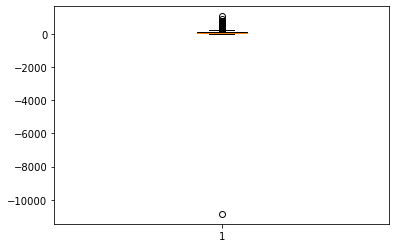

In [211]:
# ## age outlier
# plt.boxplot(df['age'])
# plt.show()

In [212]:
# print(df[df.age > 20000])
# print(df[df.age < 0])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, age, remaining_coe]
Index: []

[0 rows x 31 columns]
      listing_id                                              title  \
6300      976150  Mercedes-Benz G-Class G350d AMG Line 4MATIC Pr...   

               make model                                        description  \
6300  mercedes-benz   amg  5 years warranty or 130,000km. call our friend...   

      manufactured original_reg_date     reg_date type_of_vehicle  \
6300        2925.0               NaN  03-mar-2021             suv   

                                               category  ...       omv  \
6300  parf car, almost new car, premium ad car, low ...  ...  109673.0   

     

In [444]:
# age,power, enginecap
df[df.age < 0]['age'] = 0
df[df.age > 20000]['age'] = 0

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [445]:
##train
print(df[df.engine_cap == 0])
df.at[8199, 'engine_cap'] = np.nan

      listing_id                                              title  \
8199     1005670  Mercedes-Benz E-Class E300e Plug-in Hybrid AMG...   

               make model                                        description  \
8199  mercedes-benz   amg  great deal! grab it! new facelifted 2021 with ...   

      manufactured original_reg_date     reg_date type_of_vehicle  \
8199        2021.0               NaN  16-jun-2021    luxury sedan   

                                               category  ...      omv  \
8199  parf car, almost new car, low mileage car, hyb...  ...  52492.0   

          arf  opc_scheme lifespan   eco_category  \
8199  66486.0         NaN      NaN  uncategorized   

                                               features  \
8199  2.0l m274 powerplant with eq boost producing 3...   

                                            accessories  indicative_price  \
8199  amg kits and wheels, memory seat, ambient ligh...               NaN   

      age  remaining_coe  
81

In [ ]:
plt.boxplot(df['engine_cap'].dropna())

In [446]:
df_valid = df.dropna(subset = ['power'])
ps = df_valid['power'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['power']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'power'] = np.average(mapper[model])

print(df['power'].isnull().sum())

1982


In [447]:
df_valid = df.dropna(subset = ['engine_cap'])
ps = df_valid['engine_cap'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['engine_cap']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'engine_cap'] = np.average(mapper[model])

print(df['engine_cap'].isnull().sum())

67


In [448]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

In [449]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0
10000
0


df_ = df.copy()
df_['efficiency'] = df_['power']
for i in range(len(df_)):
    x = df_.iloc[i]
    df_['efficiency'][i] = x['power'] / x['engine_cap']

plt.boxplot(df_[df_.fuel_type == 'diesel']['efficiency'])# / diesel['engine_cap'])
plt.show()

In [450]:
# plt.boxplot(df['power'])# / diesel['engine_cap'])
# plt.show()

In [451]:
# plt.boxplot(df['engine_cap'])# / diesel['engine_cap'])
# plt.show()

plt.boxplot(df_[df_.fuel_type == 'petrol']['efficiency'])# / diesel['engine_cap']) ##outlier
plt.show()

# fill omv, get data with missing omv and dereg_value, fill in the omv
is_ = df[df.omv.isnull() & df.dereg_value.isnull()].index.tolist()
filled_omvs = []
for idx in is_:
    ag = df.at[idx, 'age']
    price = df.at[idx, 'price']
    mo = reg.predict(np.array([[ag, price]]))
    filled_omvs.append(mo)
for i, idx in enumerate(is_):
    df.at[idx, 'omv'] = filled_omvs[i]

In [ ]:
print(df['coe'].isnull().sum())

In [ ]:
plt.boxplot(df['coe'].dropna())
plt.show()

In [452]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull()]
for idx, row in fill_arf.iterrows():
    omv = row['omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

0


In [453]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

32


In [454]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

0
10000
1130


In [455]:
avg = np.average(df[df.coe.isnull()]['coe'])
df['coe'] = df['coe'].fillna(avg)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21751 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         21751 non-null  int64  
 1   title              21751 non-null  object 
 2   make               21751 non-null  object 
 3   model              21751 non-null  object 
 4   description        21295 non-null  object 
 5   manufactured       21497 non-null  float64
 6   original_reg_date  415 non-null    object 
 7   reg_date           21490 non-null  object 
 8   type_of_vehicle    21751 non-null  object 
 9   category           21751 non-null  object 
 10  transmission       21751 non-null  object 
 11  curb_weight        21040 non-null  float64
 12  power              21751 non-null  float64
 13  fuel_type          4539 non-null   object 
 14  engine_cap         21751 non-null  float64
 15  no_of_owners       21520 non-null  float64
 16  depreciation       2118

In [457]:
df.to_csv('train_test_combined.csv')

In [471]:
df = pd.read_csv('train_test_combined.csv')

In [474]:
df[:trainLen].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16751 entries, 0 to 16750
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16751 non-null  int64  
 1   listing_id         16751 non-null  int64  
 2   title              16751 non-null  object 
 3   make               16751 non-null  object 
 4   model              16751 non-null  object 
 5   description        16406 non-null  object 
 6   manufactured       16558 non-null  float64
 7   original_reg_date  315 non-null    object 
 8   reg_date           16551 non-null  object 
 9   type_of_vehicle    16751 non-null  object 
 10  category           16751 non-null  object 
 11  transmission       16751 non-null  object 
 12  curb_weight        16196 non-null  float64
 13  power              16751 non-null  float64
 14  fuel_type          3488 non-null   object 
 15  engine_cap         16751 non-null  float64
 16  no_of_owners       165

In [476]:
prices = pd.read_csv('train.csv')['price']
print(len(prices))
pi = df[:trainLen].index
prices = prices[pi]
print(len(prices))

16784
16751


In [477]:
import math
for idx, row in df.iterrows():
    if pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        remaining_coe = row['remaining_coe']
        depreciation = row['depreciation']
        if type(depreciation) == float and not pd.isna(depreciation) and idx < trainLen:
            min_parf = min(omv, arf)
            if age <= 96:
                min_parf = 0.5 * arf
            new_coe = (prices.iloc[idx] - 0.5 * min_parf) / depreciation
            if new_coe <= 120 and new_coe >= 0:
                remaining_coe = new_coe
        coe_rebate = coe * remaining_coe / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [479]:
## train
df_train = df[:trainLen]
df_test = df[trainLen:]
df_train.to_csv('train_raw.csv')
df_test.to_csv('test_raw.csv')


In [258]:
df_train = pd.read_csv('train_raw.csv')
df_test = pd.read_csv('test_raw.csv')

In [481]:
df = df_train.dropna(subset = ['depreciation', 'dereg_value'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16316 entries, 0 to 16750
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         16316 non-null  int64  
 1   listing_id         16316 non-null  int64  
 2   title              16316 non-null  object 
 3   make               16316 non-null  object 
 4   model              16316 non-null  object 
 5   description        15977 non-null  object 
 6   manufactured       16312 non-null  float64
 7   original_reg_date  40 non-null     object 
 8   reg_date           16316 non-null  object 
 9   type_of_vehicle    16316 non-null  object 
 10  category           16316 non-null  object 
 11  transmission       16316 non-null  object 
 12  curb_weight        15968 non-null  float64
 13  power              16316 non-null  float64
 14  fuel_type          3404 non-null   object 
 15  engine_cap         16316 non-null  float64
 16  no_of_owners       163

In [482]:
df_test_ = df_test.copy()
for idx, row in df_test.iterrows():
    if pd.isnull(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        remaining_coe = row['remaining_coe']
        coe_rebate = coe * remaining_coe / 120
        dereg_value = parf_ratio * arf + coe_rebate
        df_test_.at[idx, "dereg_value"] = dereg_value

df_test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 16751 to 21750
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5000 non-null   int64  
 1   listing_id         5000 non-null   int64  
 2   title              5000 non-null   object 
 3   make               5000 non-null   object 
 4   model              5000 non-null   object 
 5   description        4889 non-null   object 
 6   manufactured       4939 non-null   float64
 7   original_reg_date  100 non-null    object 
 8   reg_date           4939 non-null   object 
 9   type_of_vehicle    5000 non-null   object 
 10  category           5000 non-null   object 
 11  transmission       5000 non-null   object 
 12  curb_weight        4844 non-null   float64
 13  power              5000 non-null   float64
 14  fuel_type          1051 non-null   object 
 15  engine_cap         5000 non-null   float64
 16  no_of_owners       

In [483]:
df_test = df_test_.copy()
useful = ['depreciation', 'omv', 'arf', 'age', 'remaining_coe', 'dereg_value', 'truck', 'suv', 'sports car', 'luxury sedan',\
         'bus/mini bus', 'mid-sized sedan', 'stationwagon', 'hatchback', 'mpv']
cars_dummies = pd.get_dummies(df_test['type_of_vehicle'])
df_test = pd.concat([df_test, cars_dummies], axis=1)
df_test = df_test[useful]
df_test.to_csv('./test/with_dep.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 16751 to 21750
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depreciation     4868 non-null   float64
 1   omv              5000 non-null   float64
 2   arf              5000 non-null   float64
 3   age              5000 non-null   int64  
 4   remaining_coe    5000 non-null   int64  
 5   dereg_value      5000 non-null   float64
 6   truck            5000 non-null   uint8  
 7   suv              5000 non-null   uint8  
 8   sports car       5000 non-null   uint8  
 9   luxury sedan     5000 non-null   uint8  
 10  bus/mini bus     5000 non-null   uint8  
 11  mid-sized sedan  5000 non-null   uint8  
 12  stationwagon     5000 non-null   uint8  
 13  hatchback        5000 non-null   uint8  
 14  mpv              5000 non-null   uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 278.4 KB


In [484]:
# l = df_test[~df_test.depreciation.isnull()]['listing_id'].tolist()
# print(l)
# df_test = pd.read_csv('./test/with_dep.csv')
depL = df_test[df_test.depreciation.isnull()].index.tolist()
L = set(omvL + depL)
df_test = df_test.dropna(subset=['depreciation'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4868 entries, 16751 to 21750
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depreciation     4868 non-null   float64
 1   omv              4868 non-null   float64
 2   arf              4868 non-null   float64
 3   age              4868 non-null   int64  
 4   remaining_coe    4868 non-null   int64  
 5   dereg_value      4868 non-null   float64
 6   truck            4868 non-null   uint8  
 7   suv              4868 non-null   uint8  
 8   sports car       4868 non-null   uint8  
 9   luxury sedan     4868 non-null   uint8  
 10  bus/mini bus     4868 non-null   uint8  
 11  mid-sized sedan  4868 non-null   uint8  
 12  stationwagon     4868 non-null   uint8  
 13  hatchback        4868 non-null   uint8  
 14  mpv              4868 non-null   uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 309.0 KB


In [485]:
# useful = ['depreciation', 'omv', 'arf', 'age', 'remaining_coe', 'dereg_value', 'truck', 'suv', 'sports car', 'luxury sedan',\
#          'bus/mini bus', 'mid-sized sedan', 'stationwagon', 'hatchback', 'mpv']
# df_test = df_test[useful]
df_test.to_csv('./test/without_null_dep.csv')

In [ ]:

# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['model']
#     m2 = row['mileage'] // 500 * 500
#     a = row['age'] // 18 * 18
#     t = (m1,m2,a)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['model']
#         m2 = row['mileage'] // 500 * 500
#         a = row['age'] // 18 * 18
#         t = (m1,m2,a)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['model']
#     m2 = row['mileage'] // 1000 * 1000
#     a = row['age'] // 48 * 48
#     t = (m1,m2,a)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['model']
#         m2 = row['mileage']// 1000 * 1000
#         a = row['age'] // 48 * 48
#         t = (m1,m2,a)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['make']
#     m2 = row['mileage'] // 500 * 500
#     a = row['age'] // 18 * 18
#     p = row['power'] // 20 *20
#     t = (m1,m2,a, p)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['make']
#         m2 = row['mileage'] // 500 * 500
#         a = row['age'] // 18 * 18
#         p = row['power'] // 20 *20
#         t = (m1,m2,a, p)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['make']
#     m2 = row['mileage'] // 500 * 500
#     a = row['age'] // 18 * 18
#     p = row['power'] // 50 * 50
#     t = (m1,m2,a, p)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['make']
#         m2 = row['mileage'] // 500 * 500
#         a = row['age'] // 18 * 18
#         p = row['power'] // 50 * 50
#         t = (m1,m2,a, p)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['model']
#     a = row['age'] // 24 * 24
#     t = (m1,a)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['model']
#         a = row['age'] // 24 * 24
#         t = (m1,a)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['model']
#     a = row['age'] // 48 * 48
#     t = (m1,a)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['model']
#         a = row['age'] // 48 * 48
#         t = (m1,a)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [ ]:
# # depreciation: model, age, mileage based on df
# mam_dep = defaultdict(list)
# for idx, row in df.iterrows():
#     #500
#     m1 = row['make']
#     a = row['age'] // 48 * 48
#     p = row['power'] // 50 * 50
#     t = (m1,a, p)
#     mam_dep[t].append(row['depreciation'])

# for idx, row in df_test.iterrows():
#     #500
#     dep = row['depreciation']
#     if type(dep) == float and pd.isna(dep):
#         m1 = row['make']
#         a = row['age'] // 48 * 48
#         p = row['power'] // 50 * 50
#         t = (m1,a, p)
#         df_test.at[idx, 'depreciation'] = np.average(mam_dep[t])
# print(df_test['depreciation'].isnull().sum())

In [248]:

# for idx, row in df_test.iterrows():
#     if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
#         max_age = 10 * 12
#         age = row["age"]
#         time_left = max_age - age
#         coe = row["coe"]
#         omv = row["omv"]
#         arf = row["arf"]
#         parf_ratio = 0
#         if age <  5 * 12:
#             parf_ratio = 0.75
#         elif age >= 5 * 12 and age < 10 * 12:
#             parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
#         remaining_coe = row['remaining_coe']
#         depreciation = row['depreciation']
#         coe_rebate = coe * remaining_coe / 120
#         dereg_value = parf_ratio * arf + coe_rebate
#         if dereg_value <= 0:
#             dereg_value = 0
#         df_test.at[idx, "dereg_value"] = dereg_value
# # df_test = df_test.dropna()
# df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4863 entries, 0 to 4993
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4863 non-null   int64  
 1   Unnamed: 0.1     4863 non-null   int64  
 2   depreciation     4863 non-null   float64
 3   omv              4863 non-null   float64
 4   arf              4863 non-null   float64
 5   age              4863 non-null   int64  
 6   remaining_coe    4863 non-null   int64  
 7   dereg_value      4860 non-null   float64
 8   truck            4863 non-null   int64  
 9   suv              4863 non-null   int64  
 10  sports car       4863 non-null   int64  
 11  luxury sedan     4863 non-null   int64  
 12  bus/mini bus     4863 non-null   int64  
 13  mid-sized sedan  4863 non-null   int64  
 14  stationwagon     4863 non-null   int64  
 15  hatchback        4863 non-null   int64  
 16  mpv              4863 non-null   int64  
dtypes: float64(4),

16256
16256


In [486]:
cars_dummies = pd.get_dummies(df['type_of_vehicle'])
train = pd.concat([df, cars_dummies], axis=1)
train = train.dropna(subset=['dereg_value'])
useful = ['depreciation', 'omv', 'arf', 'age', 'remaining_coe', 'dereg_value', 'truck', 'suv', 'sports car', 'luxury sedan',\
         'bus/mini bus', 'mid-sized sedan', 'stationwagon', 'hatchback', 'mpv']
train = train[useful]
train.info()

old_train = pd.read_csv('train.csv')['price']
vi = train.index
prices = old_train[vi]
print(len(prices))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16316 entries, 0 to 16750
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depreciation     16316 non-null  float64
 1   omv              16316 non-null  float64
 2   arf              16316 non-null  float64
 3   age              16316 non-null  int64  
 4   remaining_coe    16316 non-null  int64  
 5   dereg_value      16316 non-null  float64
 6   truck            16316 non-null  uint8  
 7   suv              16316 non-null  uint8  
 8   sports car       16316 non-null  uint8  
 9   luxury sedan     16316 non-null  uint8  
 10  bus/mini bus     16316 non-null  uint8  
 11  mid-sized sedan  16316 non-null  uint8  
 12  stationwagon     16316 non-null  uint8  
 13  hatchback        16316 non-null  uint8  
 14  mpv              16316 non-null  uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 1.0 MB
16316


In [488]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, prices, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
model = RandomForestRegressor(n_estimators = 500, max_features = 7, random_state=0)
# model = RandomForestRegressor(n_estimators = 300)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
print(mse)

18751055537.10862


In [380]:
model = RandomForestRegressor(n_estimators = 600, max_features = 7, random_state=0)
# # model = RandomForestRegressor(n_estimators = 300)
model.fit(train, y)
# model.fit(X, y)

RandomForestRegressor(max_features=7, n_estimators=600, random_state=0)

In [425]:
# df_test = df_test.drop(columns=['Unnamed: 0'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4868 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depreciation     4868 non-null   float64
 1   omv              4868 non-null   float64
 2   arf              4868 non-null   float64
 3   age              4868 non-null   int64  
 4   remaining_coe    4868 non-null   int64  
 5   dereg_value      4868 non-null   float64
 6   truck            4868 non-null   int64  
 7   suv              4868 non-null   int64  
 8   sports car       4868 non-null   int64  
 9   luxury sedan     4868 non-null   int64  
 10  bus/mini bus     4868 non-null   int64  
 11  mid-sized sedan  4868 non-null   int64  
 12  stationwagon     4868 non-null   int64  
 13  hatchback        4868 non-null   int64  
 14  mpv              4868 non-null   int64  
dtypes: float64(4), int64(11)
memory usage: 608.5 KB


In [383]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16253 entries, 0 to 16717
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depreciation     16253 non-null  float64
 1   omv              16253 non-null  float64
 2   arf              16253 non-null  float64
 3   age              16253 non-null  int64  
 4   remaining_coe    16253 non-null  int64  
 5   dereg_value      16253 non-null  float64
 6   truck            16253 non-null  uint8  
 7   suv              16253 non-null  uint8  
 8   sports car       16253 non-null  uint8  
 9   luxury sedan     16253 non-null  uint8  
 10  bus/mini bus     16253 non-null  uint8  
 11  mid-sized sedan  16253 non-null  uint8  
 12  stationwagon     16253 non-null  uint8  
 13  hatchback        16253 non-null  uint8  
 14  mpv              16253 non-null  uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 1.0 MB


In [426]:
# newU = ['depreciation', 'omv', 'arf', 'age', 'remaining_coe', 'dereg_value', 'truck', 'suv', 'sports car', 'luxury sedan',\
#          'bus/mini bus', 'mid-sized sedan', 'stationwagon', 'hatchback', 'mpv']
y_pred = model.predict(df_test)
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('predictions_miss2.csv')
y_pred = y_pred.rename(columns={0: 'Predicted'})
# y_pred = y_pred.dropna()
y_pred.info()

AttributeError: 'str' object has no attribute 'predict'

In [385]:
 y_pred.to_csv('predictions_miss.csv')

In [391]:
temp = pd.read_csv('predictions_miss.csv')
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4868 entries, 0 to 4867
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4868 non-null   int64  
 1   Predicted   4868 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 76.2 KB


In [386]:
new_preds = y_pred['Predicted'].tolist()

In [387]:
cur_best = pd.read_csv('highest.csv')
cur_pred = cur_best['Predicted'].tolist()

In [394]:
print(len(new_preds)) ####

4868


In [393]:
combined_preds = []
j = 0
for i in range(5000):
    if i in L:
        old = cur_pred[i]
        combined_preds.append(old)
    else:
        new = new_preds[j]
        j += 1
        combined_preds.append(new)
print(j)
print(len(L) - 1)
print(len(combined_preds))

4863
137
5000


In [360]:
print(j)
print(len(L) - 1 + j)

4863
5000


In [389]:
sr = pd.DataFrame(combined_preds)
sr = sr.rename(columns={0: 'Predicted'})
sr.info()
sr.to_csv('predictions2.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Predicted  5000 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB
